# **UNSW-NB15 NETWORK INTRUSION**

## **Importing Libraries**

In [ ]:
import numpy as np
import tensorflow as tf;
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV, RandomizedSearchCV;
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.tree  import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score,f1_score, roc_curve, roc_auc_score;
from sklearn.ensemble import RandomForestClassifier;
from sklearn.feature_selection import RFE
import itertools
from tabulate import tabulate



## **Importing Testing and Training Dataset**

In [ ]:
train=pd.read_csv('UNSW_NB15_training-set.csv')

In [ ]:
test=pd.read_csv('UNSW_NB15_testing-set.csv')

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82332 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 82332 non-null  int64  
 1   dur                82332 non-null  float64
 2   proto              82332 non-null  object 
 3   service            82332 non-null  object 
 4   state              82332 non-null  object 
 5   spkts              82332 non-null  int64  
 6   dpkts              82332 non-null  int64  
 7   sbytes             82332 non-null  int64  
 8   dbytes             82332 non-null  int64  
 9   rate               82332 non-null  float64
 10  sttl               82332 non-null  int64  
 11  dttl               82332 non-null  int64  
 12  sload              82332 non-null  float64
 13  dload              82332 non-null  float64
 14  sloss              82332 non-null  int64  
 15  dloss              82332 non-null  int64  
 16  sinpkt             823

In [ ]:
train.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,82332.000000,82332.000000,82332.000000,82332.000000,8.233200e+04,8.233200e+04,8.233200e+04,82332.000000,82332.000000,8.233200e+04,...,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000,82332.000000
mean,41166.500000,1.006756,18.666472,17.545936,7.993908e+03,1.323379e+04,8.241089e+04,180.967667,95.713003,6.454902e+07,...,4.928898,3.663011,7.456360,0.008284,0.008381,0.129743,6.468360,9.164262,0.011126,0.550600
std,23767.345519,4.710444,133.916353,115.574086,1.716423e+05,1.514715e+05,1.486204e+05,101.513358,116.667722,1.798618e+08,...,8.389545,5.915386,11.415191,0.091171,0.092485,0.638683,8.543927,11.121413,0.104891,0.497436
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,20583.750000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,2.860611e+01,62.000000,0.000000,1.120247e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,0.000000,0.000000
50%,41166.500000,0.014138,6.000000,2.000000,5.340000e+02,1.780000e+02,2.650177e+03,254.000000,29.000000,5.770032e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000
75%,61749.250000,0.719360,12.000000,10.000000,1.280000e+03,9.560000e+02,1.111111e+05,254.000000,252.000000,6.514286e+07,...,4.000000,3.000000,6.000000,0.000000,0.000000,0.000000,7.000000,11.000000,0.000000,1.000000
max,82332.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,253.000000,5.268000e+09,...,59.000000,38.000000,63.000000,2.000000,2.000000,16.000000,60.000000,62.000000,1.000000,1.000000


In [ ]:
train.describe(include='object')

,proto,service,state,attack_cat
count,82332,82332,82332,82332
unique,131,13,7,10
top,tcp,-,FIN,Normal
freq,43095,47153,39339,37000


In [ ]:
train.isnull().sum()

,0
id,0
dur,0
proto,0
service,0
state,0
spkts,0
dpkts,0
sbytes,0
dbytes,0
rate,0


In [ ]:
print(f"Number of duplicate rows: {train.duplicated().sum()}")

Number of duplicate rows: 0


## **Attack Classes**

<Axes: xlabel='attack_cat', ylabel='count'>

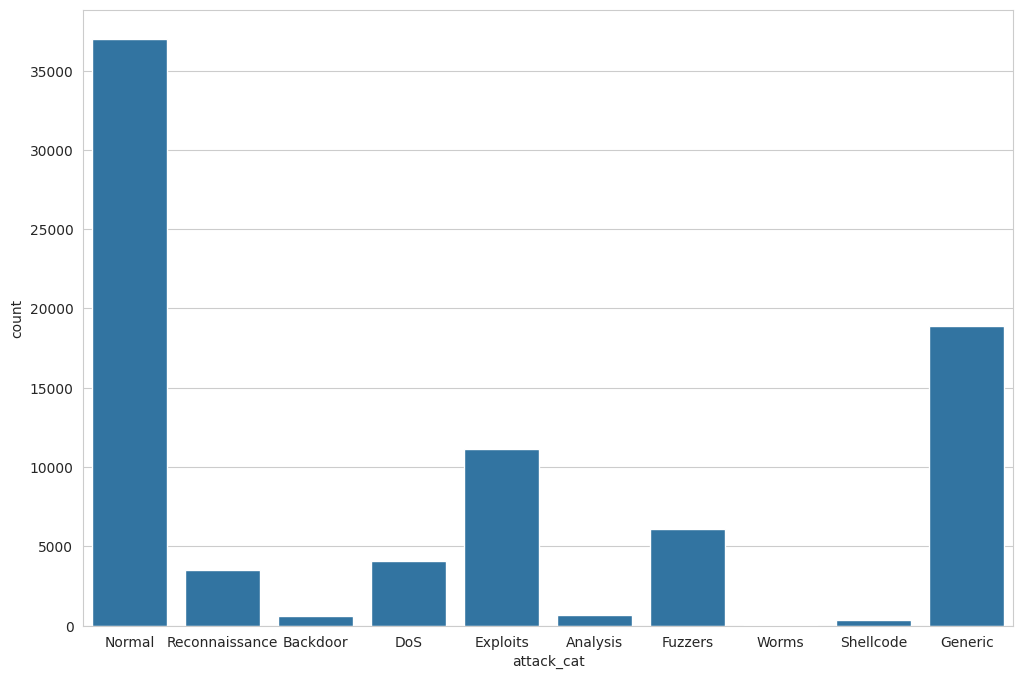

In [ ]:
plt.figure(figsize=(12, 8))
sns.set_style("whitegrid")
sns.countplot(x=train['attack_cat'])

In [ ]:
print("Attack class Distribution:-");
print(train['attack_cat'].value_counts())

Attack class Distribution:-
attack_cat
Normal            37000
Generic           18871
Exploits          11132
Fuzzers            6062
DoS                4089
Reconnaissance     3496
Analysis            677
Backdoor            583
Shellcode           378
Worms                44
Name: count, dtype: int64


## **Test-set lables**

<Axes: xlabel='label', ylabel='count'>

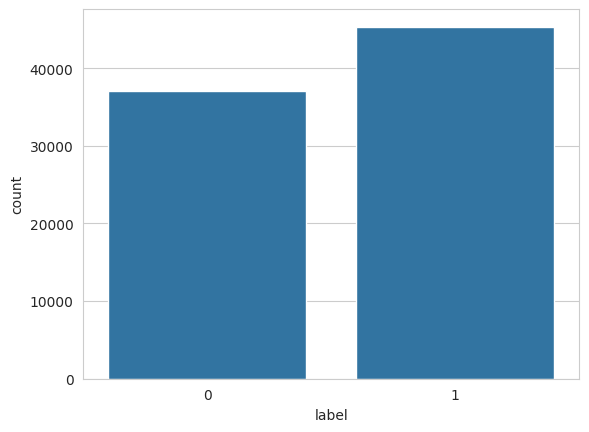

In [ ]:
sns.countplot(x=train['label'])

In [ ]:
print('Class distribution Training set:')
print(train['label'].value_counts())

Class distribution Training set:
label
1    45332
0    37000
Name: count, dtype: int64


## **Data Pre-Processing**

In [ ]:
def le(df):
    for col in df.columns:
        if df[col].dtype == 'object':
                label_encoder = LabelEncoder()
                df[col] = label_encoder.fit_transform(df[col])

le(train)
le(test)

In [ ]:
train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,117,0,4,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,6,0
1,2,0.000008,117,0,4,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,6,0
2,3,0.000005,117,0,4,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,6,0
3,4,0.000006,117,0,4,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,6,0
4,5,0.000010,117,0,4,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,6,0


In [ ]:
X_train = train.drop(['id','label'], axis=1)
Y_train = train['label']

In [ ]:
X_test=test.drop(['id','label'],axis=1)
Y_test=test['label']

### **Feature Selection**

In [ ]:
from re import X
rfc = RandomForestClassifier()

rfe = RFE(rfc, n_features_to_select=10)
rfe = rfe.fit(X_train, Y_train)

selected_features =X_train.columns[rfe.support_]


selected_features

Index(['sbytes', 'rate', 'sttl', 'sload', 'smean', 'ct_state_ttl',
       'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'ct_srv_dst', 'attack_cat'],
      dtype='object')

In [ ]:
X_train = X_train[selected_features]
X_test = X_test[selected_features]

### **Feature Scaling**

In [ ]:
scale = StandardScaler()
X_train = scale.fit_transform(X_train)
X_test = scale.fit_transform(X_test)

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train,X_test, train_size=0.70, random_state=2)

In [ ]:
print(X_train)
print(Y_train)


[[-0.04368361  0.05718096  0.71944006 ... -0.47799398 -0.64419018
   0.70710473]
 [-0.03630776  0.28656484  0.71944006 ... -0.47799398 -0.64419018
   0.70710473]
 [-0.04035108  0.79120941  0.71944006 ... -0.39039089 -0.554273
   0.70710473]
 ...
 [-0.04630536 -0.55450938 -1.78270891 ... -0.56559707 -0.73410735
   0.70710473]
 [-0.04630536 -0.55450938 -1.78270891 ... -0.56559707 -0.73410735
   0.70710473]
 [-0.04596744  0.19311212  0.71944006 ... -0.56559707 -0.73410735
   0.70710473]]
0        0
1        0
2        0
3        0
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 82332, dtype: int64


## **Decision Tree**

In [ ]:
Decision_classifier=DecisionTreeClassifier(criterion='entropy')
Decision_classifier.fit(X_train,Y_train)

Decision_pred=Decision_classifier.predict(X_test)
print(Decision_pred)

[0 0 0 ... 1 1 1]


In [ ]:
Cross_val_decision_accuracy=cross_val_score(estimator=Decision_classifier,X=X_train,y=Y_train,cv=10,scoring='accuracy').mean()
print(Cross_val_decision_accuracy)

1.0


In [ ]:
parameters={
    'criterion':['gini','entropy'],
    'splitter':['best','random'],
    'max_features':['sqrt','log2'],
    'min_samples_split':[2,3,4,5,6,7,8,9,10],
    'min_samples_leaf':[1,2,3,4,5,6,7,8,9,10],
    'max_leaf_nodes':[10,20,30,40,50,60,70,80,90],
    'max_depth':[1,2,3,4,5,6,7,8,9,10]
}
#GridCv=GridSearchCV(estimator=Decision_classifier,param_grid=parameters,cv=10);
#GridCv.fit(X_train,Y_train)
#print(GridCv)
#print(GridCv.best_params_)
#print(GridCv.best_score_);
RandomGridCv=RandomizedSearchCV(estimator=Decision_classifier,param_distributions=parameters,cv=10,n_iter=1000);
RandomGridCv.fit(X_train,Y_train)
Decision_parameters=RandomGridCv.best_params_
print(RandomGridCv)

print(RandomGridCv.best_score_);

print(Decision_parameters)

RandomizedSearchCV(cv=10, estimator=DecisionTreeClassifier(criterion='entropy'),
                   n_iter=1000,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'max_features': ['sqrt', 'log2'],
                                        'max_leaf_nodes': [10, 20, 30, 40, 50,
                                                           60, 70, 80, 90],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'min_samples_split': [2, 3, 4, 5, 6, 7,
                                                              8, 9, 10],
                                        'splitter': ['best', 'random']})
0.998931138190675
{'splitter': 'best', 'min_samples_split': 4, '

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [ ]:
print("The tuned parameters with best score using RandomSearchCv are:-\n\n")
for key,value in Decision_parameters.items():
    print(key,":",value,"\n");

The tuned parameters with best score using RandomSearchCv are:-


splitter : best 

min_samples_split : 4 

min_samples_leaf : 7 

max_leaf_nodes : 80 

max_features : log2 

max_depth : 10 

criterion : gini 



### **R2_Score**

In [ ]:
from sklearn.metrics import r2_score;
r2_score(Y_test,Decision_pred)


1.0

### **Accuracy Score**

In [ ]:
Decision_Accuracy=accuracy_score(Decision_pred,Y_test)
print(Decision_Accuracy)

1.0


### **Precision Score**

In [ ]:
Decision_precision=precision_score(Y_test,Decision_pred)
print(Decision_precision)

1.0


### **Confusion Matrics**

In [ ]:
D_matrix=confusion_matrix(Y_test,Decision_pred)
print(D_matrix)

[[ 56000      0]
 [     0 119341]]


## **Random Forest**

In [ ]:
Random_classifier=RandomForestClassifier(n_estimators=100)
Random_classifier.fit(X_train,Y_train)

Random_pred=Random_classifier.predict(X_test)
print(Random_pred)

[0 0 0 ... 1 1 1]


In [ ]:
Cross_val_random_accuracy=cross_val_score(estimator=Random_classifier,X=X_train,y=Y_train,cv=10,scoring='accuracy').mean()
print(Cross_val_random_accuracy)


1.0


In [ ]:
parameters = {
    'n_estimators': [ 10,20,30,40,50,60,70,80, 90, 100],
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split': [2,3,4,5,6,7,8,9,10],
    'max_features': ['sqrt', 'log2'],
    'min_samples_leaf': [ 5, 10]
};

#GridCvR=GridSearchCV(estimator=Random_classifier,param_grid=parameters,cv=10, n_jobs=-1, verbose=2);
#GridCvR.fit(X_train,Y_train)
RandomCvR=RandomizedSearchCV(estimator=Random_classifier,param_distributions=parameters,cv=10,n_iter=100,n_jobs=-1, verbose=1);
RandomCvR.fit(X_train,Y_train)
Random_parameters=RandomCvR.best_params_
#Random_parameters=GridCvR.best_params_

print(Random_parameters)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits
{'n_estimators': 30, 'min_samples_split': 3, 'min_samples_leaf': 5, 'max_features': 'sqrt', 'max_depth': 8}


In [ ]:
random_param_accuracy=RandomCvR.best_score_;
print(random_param_accuracy)

1.0


### **R2_Score**

In [ ]:
r2_score(Y_test,Random_pred)

1.0

### **Accuracy_Score**

In [ ]:
Random_Accuracy=accuracy_score(Random_pred,Y_test)
print(Random_Accuracy)

1.0


### **Precision**

In [ ]:
Random_precision=precision_score(Y_test,Random_pred)
print(Random_precision)

1.0


### **Confusion Matrics**

In [ ]:
R_matrix=confusion_matrix(Y_test,Random_pred)
print(R_matrix)

[[ 56000      0]
 [     0 119341]]


## **Artificial Neural Networks**

### **Model Creation and Compilation**

In [ ]:
ANN=tf.keras.models.Sequential()

In [ ]:
ANN.add(tf.keras.layers.Dense(units=6,activation='relu'))
ANN.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

ANN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy']);


### **Training and Testing**

In [ ]:
ANN.fit(X_train,Y_train,batch_size=32,epochs=100)

Epoch 1/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - accuracy: 0.8677 - loss: 0.3108
Epoch 2/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9763 - loss: 0.0793
Epoch 3/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9991 - loss: 0.0220
Epoch 4/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9999 - loss: 0.0058
Epoch 5/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9999 - loss: 0.0017
Epoch 6/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 5.7987e-04
Epoch 7/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step - accuracy: 1.0000 - loss: 2.5731e-04
Epoch 8/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 1.4285e-04
Epoch 9/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 1.0000 - loss: 1.0734e-04
Epoch 10/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step - accuracy: 1.0000 - loss: 5.2740e-05
Epoch 11/100
2573/2573 ━━━━━━━━━━━━━━━━━━━━ 7s 2ms/step - accuracy: 1.0000 - loss: 2.2642

In [ ]:
#Cross_val_ann_accuracy=cross_val_score(estimator=ANN,X=X_train,y=Y_train,cv=10,scoring='accuracy').mean()
#print(Cross_val_ann_accuracy)

In [ ]:
ANN_pred=ANN.predict(X_test);
ANN_pred=(ANN_pred>0.5);

5480/5480 ━━━━━━━━━━━━━━━━━━━━ 7s 1ms/step


In [ ]:
for i in range(len(ANN_pred)):
    if ANN_pred[i]==True:
        ANN_pred[i]=1
    else :
        ANN_pred[i]=0

In [ ]:
ANN_r2=r2_score(Y_test,ANN_pred)
print(ANN_r2)

0.995224958312734


### **Accuracy And Precision Scores**

In [ ]:
print("Acuracy Score:-")
ANN_Accuracy=accuracy_score(ANN_pred,Y_test)
print(ANN_Accuracy)
print("\n\nPrecision Score")
ANN_precision=precision_score(Y_test,ANN_pred)
print(ANN_precision)

Acuracy Score:-
0.9989620225731575


Precision Score
0.9984939633029059


### **Confusion Matrix**

In [ ]:
confusion_ann=confusion_matrix(Y_test,ANN_pred)
print(confusion_ann)

[[ 55820    180]
 [     2 119339]]


## **ROC_CURVE**

In [ ]:
fpr_dt,tpr_dt,_=roc_curve(Y_test,Decision_pred)
fpr_rf,tpr_rf,_=roc_curve(Y_test,Random_pred)
fpr_ann,tpr_ann,_=roc_curve(Y_test,ANN_pred)

In [ ]:
auc_dt=roc_auc_score(Y_test,Decision_pred)
auc_rf=roc_auc_score(Y_test,Random_pred)
auc_ann=roc_auc_score(Y_test,ANN_pred)

In [ ]:
print(auc_dt)
print(auc_rf)
print(auc_ann);

1.0
1.0
0.998384477792927


In [ ]:
print(fpr_dt)
print(fpr_rf)
print(fpr_ann);

[0. 0. 1.]
[0. 0. 1.]
[0.         0.00321429 1.        ]


## **F1-Scores**

In [ ]:
Decision_f1=f1_score(Y_test,Decision_pred)
Random_f1=f1_score(Y_test,Random_pred)
ANN_f1=f1_score(Y_test,ANN_pred)

## **Tabuler View of Model Scores**

In [ ]:
data = [["Random Forest", Random_Accuracy,Random_precision,fpr_rf,Random_f1,Cross_val_random_accuracy],
        ["Artificial Neural Networks", ANN_Accuracy,ANN_precision,fpr_ann,ANN_f1,"NULL"],
        ["Decision Tree", Decision_Accuracy, Decision_precision,fpr_dt,Decision_f1,Cross_val_decision_accuracy]]

col_names = ["Model", "Accuracy Score","Model precision","FPR","F1-Score",'Cross-Validation Accuracy'];
print("\bAccuracy of the the 3 test modles with train and test data are:-\b");
print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

Accuracy of the the 3 test modles with train and test data are:-
╒════════════════════════════╤══════════════════╤═══════════════════╤════════════════════════════════════╤════════════╤═════════════════════════════╕
│ Model                      │   Accuracy Score │   Model precision │ FPR                                │   F1-Score │ Cross-Validation Accuracy   │
╞════════════════════════════╪══════════════════╪═══════════════════╪════════════════════════════════════╪════════════╪═════════════════════════════╡
│ Random Forest              │         1        │          1        │ [0. 0. 1.]                         │   1        │ 1.0                         │
├────────────────────────────┼──────────────────┼───────────────────┼────────────────────────────────────┼────────────┼─────────────────────────────┤
│ Artificial Neural Networks │         0.998962 │          0.998494 │ [0.         0.00321429 1.        ] │   0.999238 │ NULL                        │
├────────────────────────────┼───

## **Plotting of Scores**

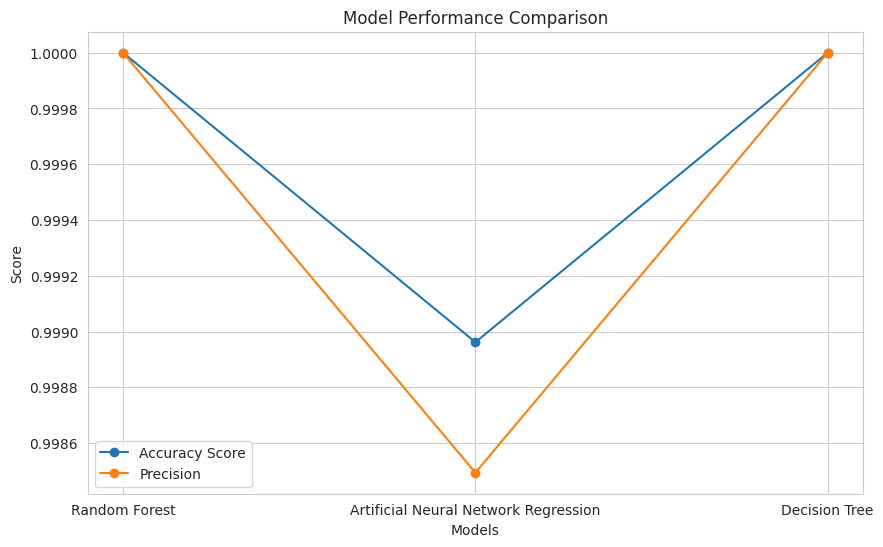

In [ ]:
models = ["Random Forest", "Artificial Neural Network Regression", "Decision Tree"]
Accuracy_scores = [Random_Accuracy,ANN_Accuracy, Decision_Accuracy]
precision_scores = [Random_precision, ANN_precision, Decision_precision]


x = range(len(models))

plt.figure(figsize=(10, 6))
plt.plot(x, Accuracy_scores, label='Accuracy Score', marker='o')
plt.plot(x, precision_scores, label='Precision', marker='o')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(True)
plt.show()


## **Ploting ROC**

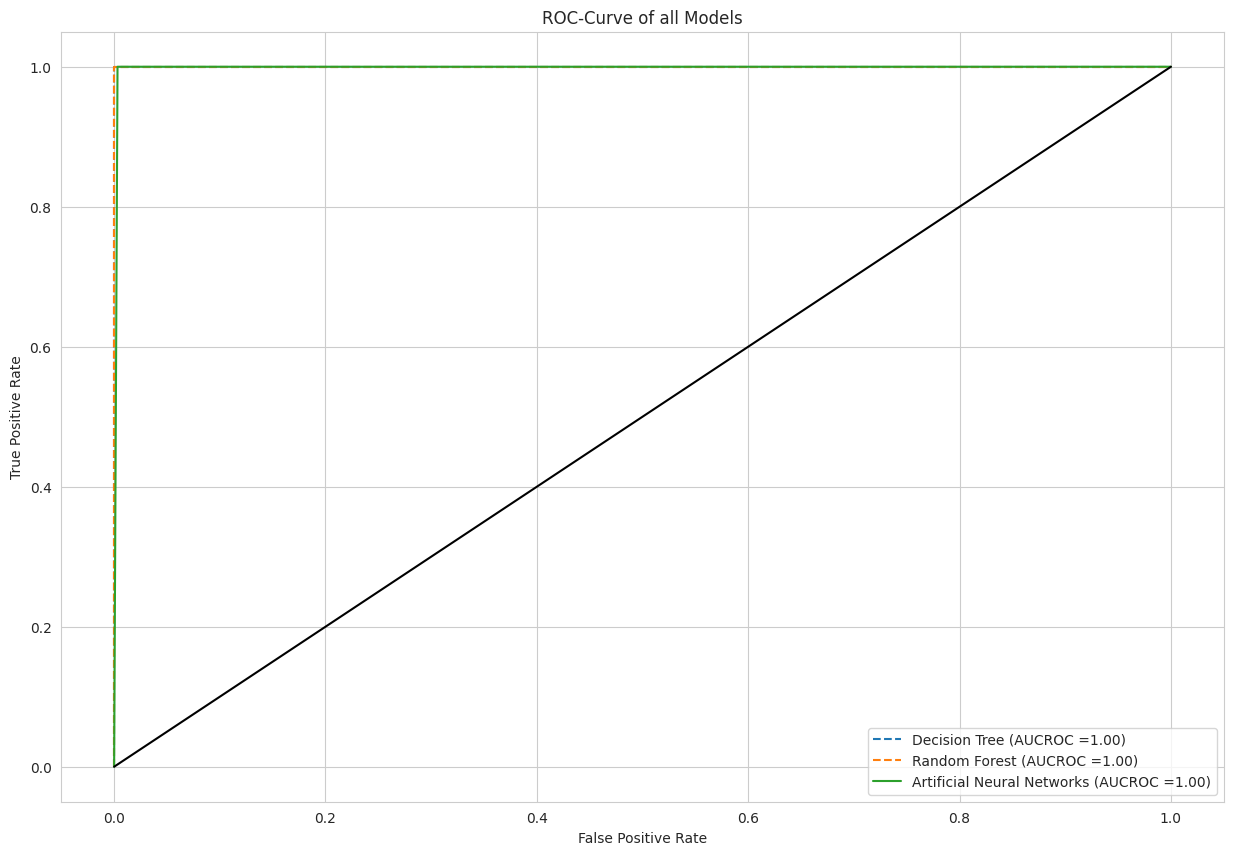

In [ ]:
plt.figure(figsize=(15,10))
plt.plot(fpr_dt, tpr_dt,linestyle="--",label=f'Decision Tree (AUCROC =%0.2f)'%auc_dt)
plt.plot(fpr_rf, tpr_rf,linestyle="--", label=f'Random Forest (AUCROC =%0.2f)'%auc_rf)
plt.plot(fpr_ann, tpr_ann ,label=f'Artificial Neural Networks (AUCROC =%0.2f)'%auc_ann)
plt.plot([0,1],color="black")  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Curve of all Models')
plt.legend()
plt.show()


## **After Tuining**

Decision Tree

In [ ]:
Decision_classifier2=DecisionTreeClassifier(**Decision_parameters)
Decision_classifier2.fit(X_train,Y_train)

Decision_pred2=Decision_classifier2.predict(X_test)


In [ ]:
Decision_accuracy_2=accuracy_score(Decision_pred2,Y_test)
print("The accuracy after tuining:-\n")
print(Decision_accuracy_2)
print("\n\nPrecision after tuining:-\n")
Decision_precision_2=precision_score(Y_test,Decision_pred2)
print(Decision_precision_2)


The accuracy after tuining:-

0.9924375930330043


Precision after tuining:-

0.9999745807949433


Random Forest

In [ ]:
Random_classifier2=RandomForestClassifier(**Random_parameters)
Random_classifier2.fit(X_train,Y_train)

Random_pred2=Random_classifier2.predict(X_test)

In [ ]:
Random_accuracy_2=accuracy_score(Random_pred2,Y_test)
print("The accuracy after tuining:-\n")
print(Random_accuracy_2)
print("\n\nPrecision after tuining:-\n")
Random_precision_2=precision_score(Y_test,Random_pred2)
print(Random_precision_2)

The accuracy after tuining:-

0.9999315619279004


Precision after tuining:-

1.0


In [ ]:
Data=[["Decision Tree", Decision_accuracy_2,Decision_precision_2],
      ["Random Forest", Random_accuracy_2,Random_precision_2]]

column=["Model","Accuracy Score","Model precision"]

print("\n\n \bPrecision and Accuracy comparision after tuining of models:-\b\n\n")
print(tabulate(Data,headers=column,tablefmt="fancy_grid"))



 Precision and Accuracy comparision after tuining of models:-


╒═══════════════╤══════════════════╤═══════════════════╕
│ Model         │   Accuracy Score │   Model precision │
╞═══════════════╪══════════════════╪═══════════════════╡
│ Decision Tree │         0.992438 │          0.999975 │
├───────────────┼──────────────────┼───────────────────┤
│ Random Forest │         0.999932 │          1        │
╘═══════════════╧══════════════════╧═══════════════════╛


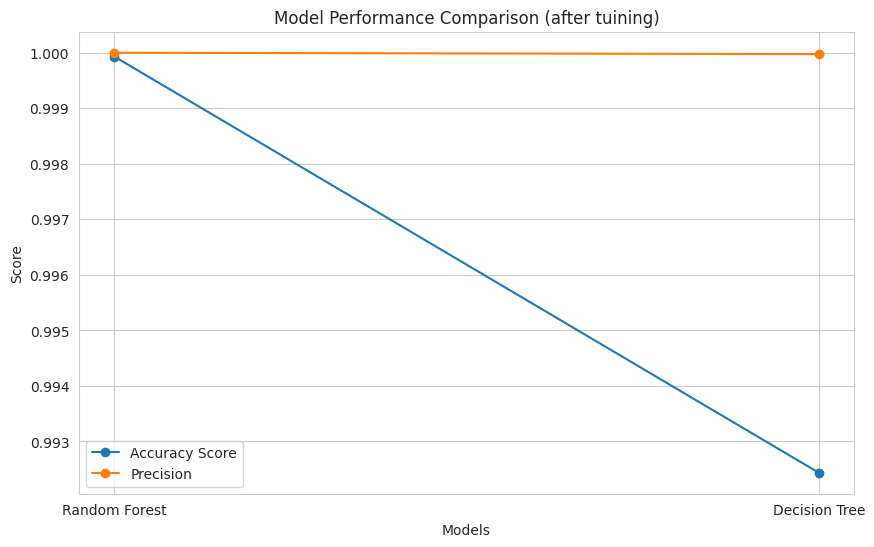

In [ ]:
models = ["Random Forest", "Decision Tree"]
Accuracy_scores_2 = [Random_accuracy_2, Decision_accuracy_2]
precision_scores_2 = [Random_precision_2, Decision_precision_2]


x = range(len(models))

plt.figure(figsize=(10, 6))
plt.plot(x, Accuracy_scores_2, label='Accuracy Score', marker='o')
plt.plot(x, precision_scores_2, label='Precision', marker='o')

plt.xticks(x, models)
plt.xlabel("Models")
plt.ylabel("Score")
plt.title("Model Performance Comparison (after tuining)")
plt.legend()
plt.grid(True)
plt.show()